# Script to plot the closed orbit in `cpymad` AKA `MAD-X`

In [1]:
# Load helper scripts
%run ../../Scripts/helper_functions.py
%run ../../Scripts/cpymad_helpers.py
%run ../../Scripts/cpymad_2025_orbit_methods.py

In [2]:
import pandas as pd

class BPMFitResultsLoader:
    def __init__(self, filepath, reverse_co=False):
        self.filepath = filepath
        self.reverse_co = reverse_co
        self.df = self._load_file()
        
    def _load_file(self):
        return pd.read_csv(self.filepath, sep=r"\s+")
    
    def get_bpm_list(self):
        return self.df['bpm'].unique().tolist()

    def get_available_parameters(self):
        return self.df.columns

    def get_parameter(self, param_name, bpm=None):
        if param_name not in self.df.columns:
            raise ValueError(f"Parameter '{param_name}' not found in data.")
        if bpm:
            return self.df[self.df['bpm'] == bpm][param_name].values
        return self.df[param_name].values

    def get_plane_parameters(self, plane="H", parameters=None):
        if parameters is None:
            parameters = self.get_available_parameters()
        missing = [p for p in parameters if p not in self.df.columns]
        if missing:
            raise ValueError(f"Missing parameters in file: {missing}")
        df_plane = self.df[self.df['plane'] == plane].copy()
        return df_plane[["bpm"] + parameters]

    def get_co_data(self, plane="H", twiss_df=None):
        required_columns = ["closed_orbit_mm", "closed_orbit_mm_err"]
        missing = [col for col in required_columns if col not in self.df.columns]
        if missing:
            raise ValueError(f"Missing required CO data columns: {missing}")
        
        df_plane = self.df[self.df['plane'] == plane].copy()
    
        if self.reverse_co:
            df_plane["closed_orbit_mm"] *= -1
    
        # Optional Twiss 's' lookup by partial BPM name
        if twiss_df is not None:
            twiss_lookup = twiss_df.copy()
            twiss_lookup["name_stripped"] = twiss_lookup["name"].astype(str).str.lower()
            bpm_to_s = {}
    
            for bpm in df_plane["bpm"]:
                bpm_key = bpm.lower()
                matched = twiss_lookup[twiss_lookup["name_stripped"].str.contains(bpm_key)]
                if len(matched) == 1:
                    bpm_to_s[bpm] = matched["s"].values[0]
                else:
                    bpm_to_s[bpm] = float("nan")  # ambiguous or not found
    
            df_plane["s"] = df_plane["bpm"].map(bpm_to_s)
    
        return df_plane[["bpm", "closed_orbit_mm", "closed_orbit_mm_err"] + (["s"] if "s" in df_plane.columns else [])]

    def get_dataframe(self):
        return self.df

In [3]:
def cpymad_set_correctors(madx_instance, cpymad_logfile, corrector_dict, max_E=800., time=0.0):
    """
    Applies the vertical corrector kick values (converted from Amperes to mrad) 
    to a cpymad MAD-X instance.

    Parameters:
    madx_instance (Madx): An instance of cpymad's MAD-X.
    cpymad_logfile (str): Path to the cpymad log file (not used in function).
    corrector_dict (dict): Dictionary with keys as MAD-X variable names 
                           and values as the programmed kicks in Amperes.
    """

    for key, amps in corrector_dict.items():
        # Extract plane ('V' from 'vd1') and super-period (from 'rX' where X is 0, 2, etc.)
        sp = int(key[1])  # Extract the second character as the super-period
        plane = 'V' if 'vd' in key else 'H'  # Determine plane from key name

        # Convert kick from Amperes to milliradians
        kick_mrad = calculate_corrector_kick(amps, max_E, time, plane, sp)

        # Print key, amps, and converted kick
        print(f"{key}: {amps:.6f} A -> {kick_mrad:.6f} mrad")

        # Apply the converted kick to MAD-X
        kick_mrad *= 1E-3 # convert from millirad to radians
        madx_instance.input(f"{key} := {kick_mrad};")


In [4]:
def calculate_corrector_kick(current_Amps, max_E, time, plane='H', sp=0):
    """
    Returns the corrector steering kick in milliradians given the desired current in amperes.

    Parameters:
    current_Amps (float): Desired current in Amperes.
    max_E (float): Maximum energy.
    time (float): Measurement time.
    plane (str): 'H' for horizontal or 'V' for vertical.
    sp (int): Super-period number.

    Returns:
    float: Corrector current in amperes.
    """
    sp_list = [0, 2, 3, 4, 5, 7, 9]
    if sp not in sp_list:
        print('calculate_corrector_current:: selected super-period has no steering magnet')
        exit(0)

    # Calibration provided by HVC 30.09.22
    calibration_data = {
        '0H': 0.08350, '2H': 0.09121, '3H': 0.08, '4H': 0.06600,
        '5H': 0.07780, '7H': 0.07580, '9H': 0.07660, '0V': 0.04620,
        '2V': 0.04330, '3V': 0.05210, '4V': 0.04770, '5V': 0.05400,
        '7V': 0.05220, '9V': 0.04510
    }

    df = synchrotron_energy_data(max_E, time)

    h_list = ['h', 'H', 'horizontal', 'Horizontal']
    key = f"{sp}{'H' if plane in h_list else 'V'}"
    
    # Compute the kick in milliradians
    kick_mrad  = current_Amps /( df['Rigidity [Tm]'].iloc[0] / calibration_data[key])

    return round_sig(kick_mrad,7)


In [5]:
def calculate_corrector_current(kick_mrad, max_E, time, plane='H', sp=0):
    """
    Returns the corrector current in amperes given the desired steering kick in milliradians.

    Parameters:
    kick_mrad (float): Desired steering kick in milliradians.
    max_E (float): Maximum energy.
    time (float): Measurement time.
    plane (str): 'H' for horizontal or 'V' for vertical.
    sp (int): Super-period number.

    Returns:
    float: Corrector current in amperes.
    """
    sp_list = [0, 2, 3, 4, 5, 7, 9]
    if sp not in sp_list:
        print('calculate_corrector_current:: selected super-period has no steering magnet')
        exit(0)

    # Calibration provided by HVC 30.09.22
    calibration_data = {
        '0H': 0.08350, '2H': 0.09121, '3H': 0.08, '4H': 0.06600,
        '5H': 0.07780, '7H': 0.07580, '9H': 0.07660, '0V': 0.04620,
        '2V': 0.04330, '3V': 0.05210, '4V': 0.04770, '5V': 0.05400,
        '7V': 0.05220, '9V': 0.04510
    }

    df = synchrotron_energy_data(max_E, time)

    h_list = ['h', 'H', 'horizontal', 'Horizontal']
    key = f"{sp}{'H' if plane in h_list else 'V'}"

    # Compute the current in amperes
    amps = kick_mrad * df['Rigidity [Tm]'].iloc[0] / calibration_data[key]

    return round_sig(amps,7)


In [6]:
def convert_kicks_to_currents(kicks_dict, max_E=800., time=0.0):
    """
    Converts a dictionary of corrector kicks in milliradians to corrector settings in amperes.

    Parameters:
    kicks_dict (dict): Dictionary where keys are corrector names and values are kicks in milliradians.
    max_E (float): Maximum energy, default is 800.
    time (float): Measurement time, default is 0.0.

    Returns:
    dict: A new dictionary with the same keys but values converted to amperes.
    """
    current_dict = {}

    for key, kick_mrad in kicks_dict.items():
        # Extract plane ('V' from 'vd1') and super-period (from 'rX' where X is 0, 2, etc.)
        sp = int(key[1])  # Extract super-period from the second character
        plane = 'V' if 'vd' in key else 'H'  # Determine plane based on key name

        # Convert the kick from milliradians to amperes
        amps = calculate_corrector_current(kick_mrad, max_E, time, plane, sp)

        # Store the converted value in the new dictionary
        current_dict[key] = amps

    return current_dict


In [7]:
def convert_currents_to_kicks(currents_dict, max_E=800., time=0.0):
    """
    Converts a dictionary of corrector settings in amperes to corrector kicks in milliradians.

    Parameters:
    currents_dict (dict): Dictionary where keys are corrector names and values are kicks in milliradians.
    max_E (float): Maximum energy, default is 800.
    time (float): Measurement time, default is 0.0.

    Returns:
    dict: A new dictionary with the same keys but values converted to amperes.
    """
    current_dict = {}

    for key, current_Amp in currents_dict.items():
        # Extract plane ('V' from 'vd1') and super-period (from 'rX' where X is 0, 2, etc.)
        sp = int(key[1])  # Extract super-period from the second character
        plane = 'V' if 'vd' in key else 'H'  # Determine plane based on key name

        # Convert the kick from milliradians to amperes
        amps = calculate_corrector_kick(current_Amp, max_E, time, plane, sp)

        # Store the converted value in the new dictionary
        current_dict[key] = amps

    return current_dict


In [8]:
def cpymad_set_isis_cycle_time(madx_instance, max_E, time):
    # Ensure time is a float and in valid increments
    if not isinstance(time, float) or time < 0.0 or time > 10.0 or (time * 10) % 5 != 0:
        print(f"Error: time must be a float between 0.0 and 10.0 in 0.5 increments. Received: {time}")
        return

    # Generate dataframe of synchrotron energy and related info
    energy_df = synchrotron_energy_df(max_E, intervals=20)

    # store some values for this time point
    try:
        energy = energy_df[energy_df['Time [ms]'] == time]['Energy [MeV]'].iloc[0]
        pc = energy_df[energy_df['Time [ms]'] == time]['Momentum [GeV/c]'].iloc[0]
    except IndexError:
        print(f"Error: No matching time value found in energy dataframe for time = {time} ms")
        return

    # set the beam to this energy in cpymad
    madx_instance.input(f'beam, particle = proton, pc = {pc};')

    # print confirmation
    print(f'ISIS cpymad run, energy set to {energy} MeV, pc = {pc}')


## `cpymad` is a (cython) python based wrapper for `Methodical Accelerator Design (MAD-X)`, originally developed by CERN
This is the standard code used to define linear beam dynamics (also called beam optics) for accelerators

# 0. Make some folders
to store output plots and files

In [9]:
plot_folder = 'Orbit_Plots'
make_directory(plot_folder)

Directory Orbit_Plots exists


# 1. Instantiate a MAD-X object
Note from now on `cpymad` $\equiv$`MAD-X`

In [10]:
cpymad_logfile = 'cpymad_logfile.txt'
sequence_name = 'synchrotron'

madx = cpymad_start(cpymad_logfile)

`madx` is the simulation object, next we have to give it the description of the synchrotron, also called the **lattice**

We have a number of lattices to choose from

In [11]:
lattice_folder = '../../Lattice_Files/00_Simplified_Lattice/'
# lattice_folder = '../../Lattice_Files/01_Original_Lattice/'
# lattice_folder = '../../Lattice_Files/02_Aperture_Lattice/'
# lattice_folder = '../../Lattice_Files/03_CO_Kick_Lattice/'
# lattice_folder = '../../Lattice_Files/04_New_Harmonics/'

In [12]:
madx.call(file=lattice_folder+'ISIS.injected_beam')
madx.call(file=lattice_folder+'ISIS.strength')
madx.call(file=lattice_folder+'2023.strength')
madx.call(file=lattice_folder+'ISIS.elements')
madx.call(file=lattice_folder+'ISIS.sequence')

`cpymad` must check if a sequence is properly defined, and then **use** a single sequence at a time for calculations

In [13]:
cpymad_check_and_use_sequence(madx, cpymad_logfile, sequence_name)

Sequence  synchrotron  is active.


True

# 2. Set the cycle time = beam energy

To initialise the simulation `cpymad` first calculates the optics parameters, this includes the closed orbit, or beam trajectory. `cpymad` calls this a **twiss** file, which is stored as a *.tfs file

In [ ]:
max_E = 800 # 800 MeV
cycle_time = 1.5 # 1.5 milliseconds into the 10 ms acceleration cycle of the synchrotron
cpymad_set_isis_cycle_time(madx, max_E, cycle_time)

# 3. Calculate lattice parameters using **TWISS** command

In [15]:
twiss_0 = cpymad_madx_twiss(madx, cpymad_logfile, sequence_name)

Sequence  synchrotron  is active.


The twiss table is stored as a data table in file format, and here as a pandas dataframe:

In [16]:
twiss_0

,name,keyword,s,betx,alfx,mux,bety,alfy,muy,x,...,sig54,sig55,sig56,sig61,sig62,sig63,sig64,sig65,sig66,n1
#s,synchrotron$start:1,marker,0.00000,10.518726,0.753372,0.000000,5.963206,-1.080272,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sp0_datum,sp0_datum:1,marker,0.00000,10.518726,0.753372,0.000000,5.963206,-1.080272,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sp0_dipfr8,sp0_dipfr8:1,sbend,0.16000,10.278029,0.750817,0.002449,6.319944,-1.149550,0.004149,0.0,...,0.0,0.002971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sp0_dipfr9,sp0_dipfr9:1,sbend,0.36000,9.984103,0.718831,0.005592,6.794242,-1.221912,0.009007,0.0,...,0.0,0.003986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sp0_dipfr10,sp0_dipfr10:1,sbend,0.39000,9.941119,0.713959,0.006071,6.867880,-1.232700,0.009706,0.0,...,0.0,0.004079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sp0_dip,sp0_dip:1,sbend,163.12282,10.849531,0.597172,4.312428,5.482640,-0.912872,3.758314,0.0,...,0.0,12.112036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sp0_dipfr6,sp0_dipfr6:1,sbend,163.32282,10.579016,0.753855,4.315397,5.877470,-1.063147,3.763925,0.0,...,0.0,13.459610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sp0_dipfr7,sp0_dipfr7:1,sbend,163.36282,10.518726,0.753372,4.316001,5.963206,-1.080272,3.765000,0.0,...,0.0,13.559395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sp9_end,sp9_end:1,marker,163.36282,10.518726,0.753372,4.316001,5.963206,-1.080272,3.765000,0.0,...,0.0,13.559395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The closed orbit in the horizontal is the **x** column, and vertical is the **y** column
The co-ordinate **s** is the co-moving co-ordinate

# 4. Plot the closed orbit

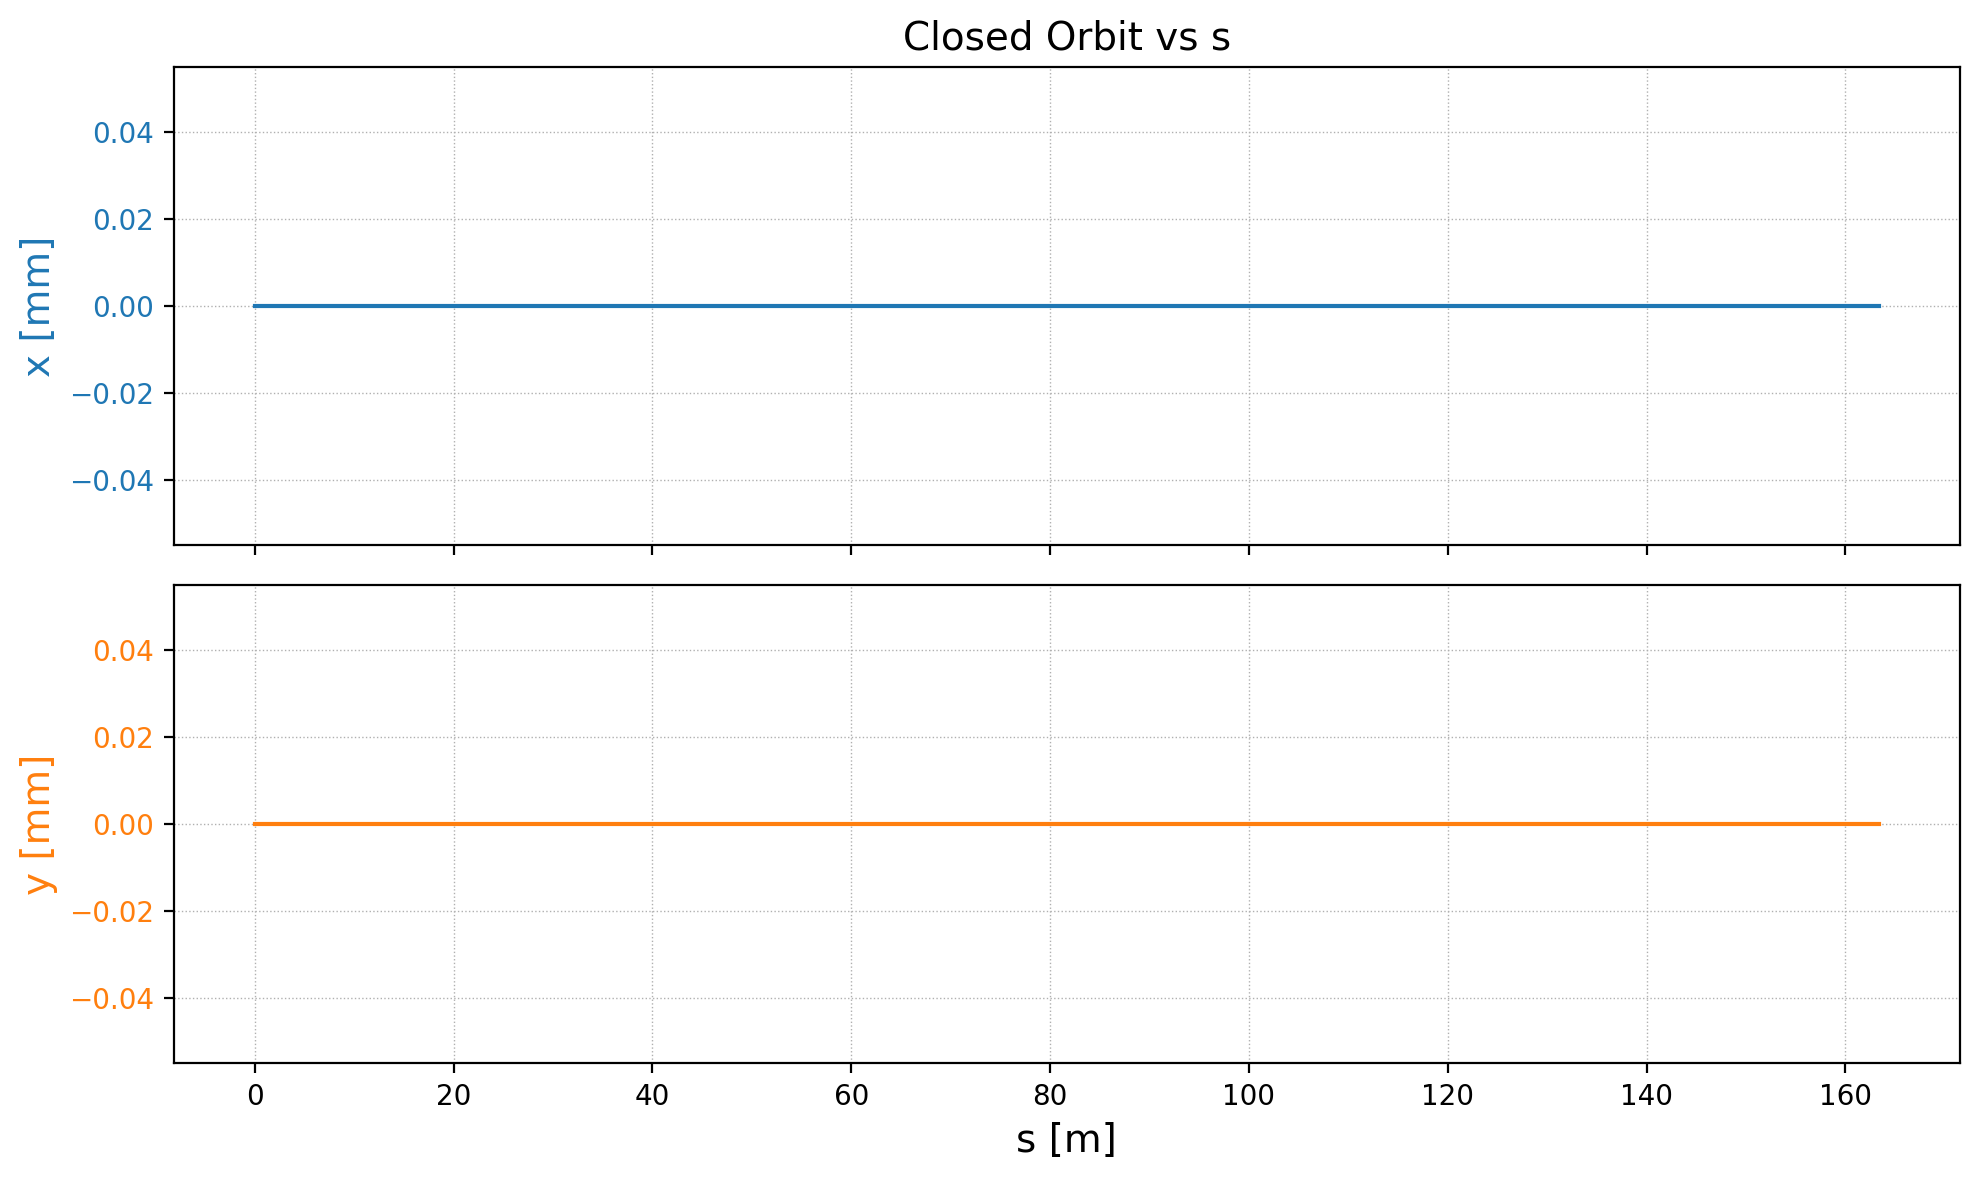

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Top subplot: x vs s
ax1.plot(twiss_0.s, twiss_0.x, color='tab:blue')
ax1.set_ylabel('x [mm]', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, which='both', linestyle=':', linewidth=0.5)
ax1.set_title('Closed Orbit vs s')

# Bottom subplot: y vs s
ax2.plot(twiss_0.s, twiss_0.y, color='tab:orange')
ax2.set_xlabel('s [m]')
ax2.set_ylabel('y [mm]', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')
ax2.grid(True, which='both', linestyle=':', linewidth=0.5)

plt.tight_layout()
plt.show()


There is a nice helper function that plots the orbits along with other useful beam dynamics parameters, in the below plot we see:
- A block diagram indicating which magnets are present in the lattice and how long they are
- The Beta functions (related to beam focussing), and the dispersion function (relates beam energy spread to resulting spread in beam size)
- The horizontal closed orbit
- The vertical closed orbit

/home/hr/Repositories/synchrotron_model/ISIS_Synchrotron_Model/Scripts/cpymad_helpers.py:1539: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  f2_ax4.set_ylim(co_min,co_max)
/home/hr/Repositories/synchrotron_model/ISIS_Synchrotron_Model/Scripts/cpymad_helpers.py:1540: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  f2_ax3.set_ylim(co_min,co_max)


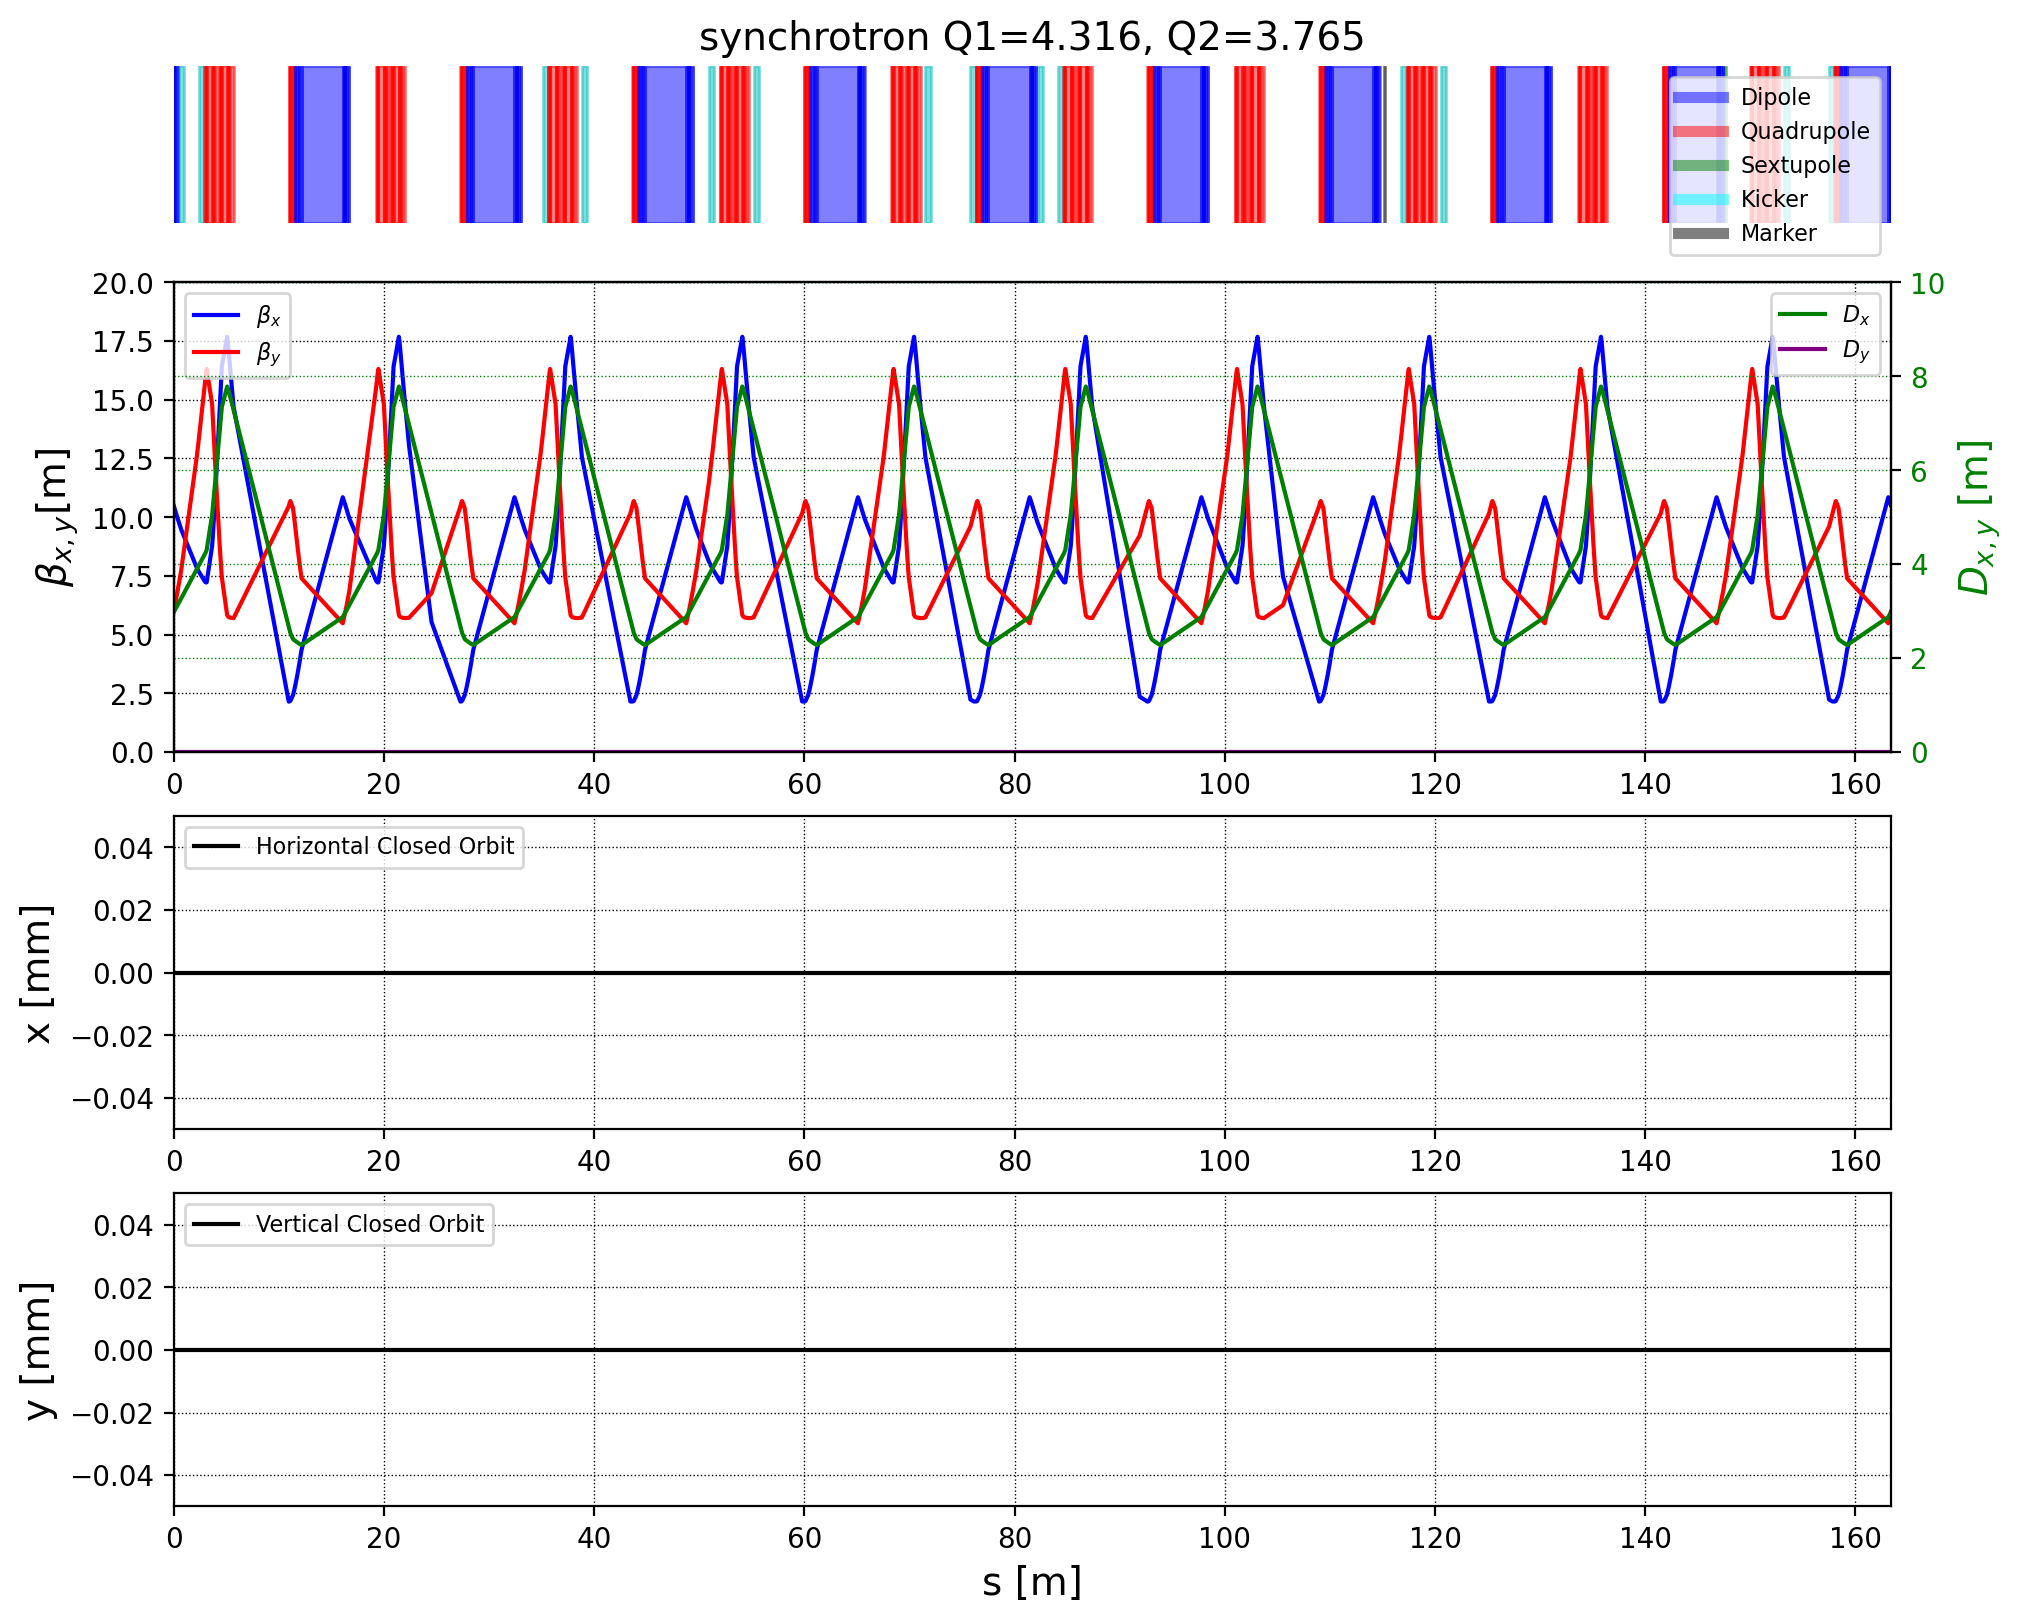

In [18]:
cpymad_plot_CO_plotly(madx, twiss_0, sequence_name, save_file=plot_folder+'/initial_lattice_CO_plotly.png') 
cpymad_plot_CO(madx, twiss_0, sequence_name, save_file=plot_folder+'/initial_lattice_CO.png')  

# 5. Set the dipole (also called orbit) correctors

Note that the initial closed orbit is 'perfect'.
Below we will turn on the corrector dipoles, but first we should check their values are zero:

In [19]:
print("r0vd1_kick =", madx.globals['r0vd1_kick'])
print("r2vd1_kick =", madx.globals['r2vd1_kick'])
print("r3vd1_kick =", madx.globals['r3vd1_kick'])
print("r4vd1_kick =", madx.globals['r4vd1_kick'])
print("r5vd1_kick =", madx.globals['r5vd1_kick'])
print("r7vd1_kick =", madx.globals['r7vd1_kick'])
print("r9vd1_kick =", madx.globals['r9vd1_kick'])

r0vd1_kick = 0.0
r2vd1_kick = 0.0
r3vd1_kick = 0.0
r4vd1_kick = 0.0
r5vd1_kick = 0.0
r7vd1_kick = 0.0
r9vd1_kick = 0.0


## Note: The controls system sets dipole correctors in Amperes, `cpymad` takes a kick in radians

In [20]:
# kicks in milliradians - remember MAD expects radians (these numbers * 1E-3)
v_corrected_dict = {
    "r0vd1_kick": -0.073474149,
    "r2vd1_kick": 0.307515168,
    "r3vd1_kick": -0.257864760,
    "r4vd1_kick": -0.019923798,
    "r5vd1_kick": -0.319146002,
    "r7vd1_kick": 0.549252123,
    "r9vd1_kick": 0.603084818,
}

In [21]:
# Convert kicks in milliradians to currents in Amperes
v_corrector_currents = convert_kicks_to_currents(v_corrected_dict)
v_corrector_currents

{'r0vd1_kick': np.float64(-1.958182),
 'r2vd1_kick': np.float64(8.744582),
 'r3vd1_kick': np.float64(-6.094172),
 'r4vd1_kick': np.float64(-0.5142972),
 'r5vd1_kick': np.float64(-7.277062),
 'r7vd1_kick': np.float64(12.95572),
 'r9vd1_kick': np.float64(16.46502)}

In [22]:
# Convert currents in Amperes to kicks in milliradians
v_corrector_kicks = convert_currents_to_kicks(v_corrector_currents)
v_corrector_kicks

{'r0vd1_kick': np.float64(-0.07347415),
 'r2vd1_kick': np.float64(0.3075152),
 'r3vd1_kick': np.float64(-0.2578648),
 'r4vd1_kick': np.float64(-0.0199238),
 'r5vd1_kick': np.float64(-0.319146),
 'r7vd1_kick': np.float64(0.549252),
 'r9vd1_kick': np.float64(0.6030848)}

The function `cpymad_set_correctors` takes this into account, reading the currents in Amps, and setting them in milliradians.
Now we will set the vertical correctors to something like operational settings. This function takes a `time` argument which defaults to 0 (milliseconds in the acceleration cycle)

In [23]:
# These values are currents in Amperes
v_corrector_currents_minus_0p4ms = {
 'r0vd1_kick': 16.3,
 'r2vd1_kick': -33.0,
 'r3vd1_kick': 30,
 'r4vd1_kick': 22.8,
 'r5vd1_kick': -21.9,
 'r7vd1_kick': -38.1,
 'r9vd1_kick': 37.8}

In [24]:
cpymad_set_correctors(madx, cpymad_logfile, v_corrector_currents_minus_0p4ms, max_E, cycle_time)

r0vd1_kick: 16.300000 A -> 0.526546 mrad
r2vd1_kick: -33.000000 A -> -0.999099 mrad
r3vd1_kick: 30.000000 A -> 1.092862 mrad
r4vd1_kick: 22.800000 A -> 0.760431 mrad
r5vd1_kick: -21.900000 A -> -0.826884 mrad
r7vd1_kick: -38.100000 A -> -1.390599 mrad
r9vd1_kick: 37.800000 A -> 1.191996 mrad


We must now recompute the **twiss** table

Sequence  synchrotron  is active.


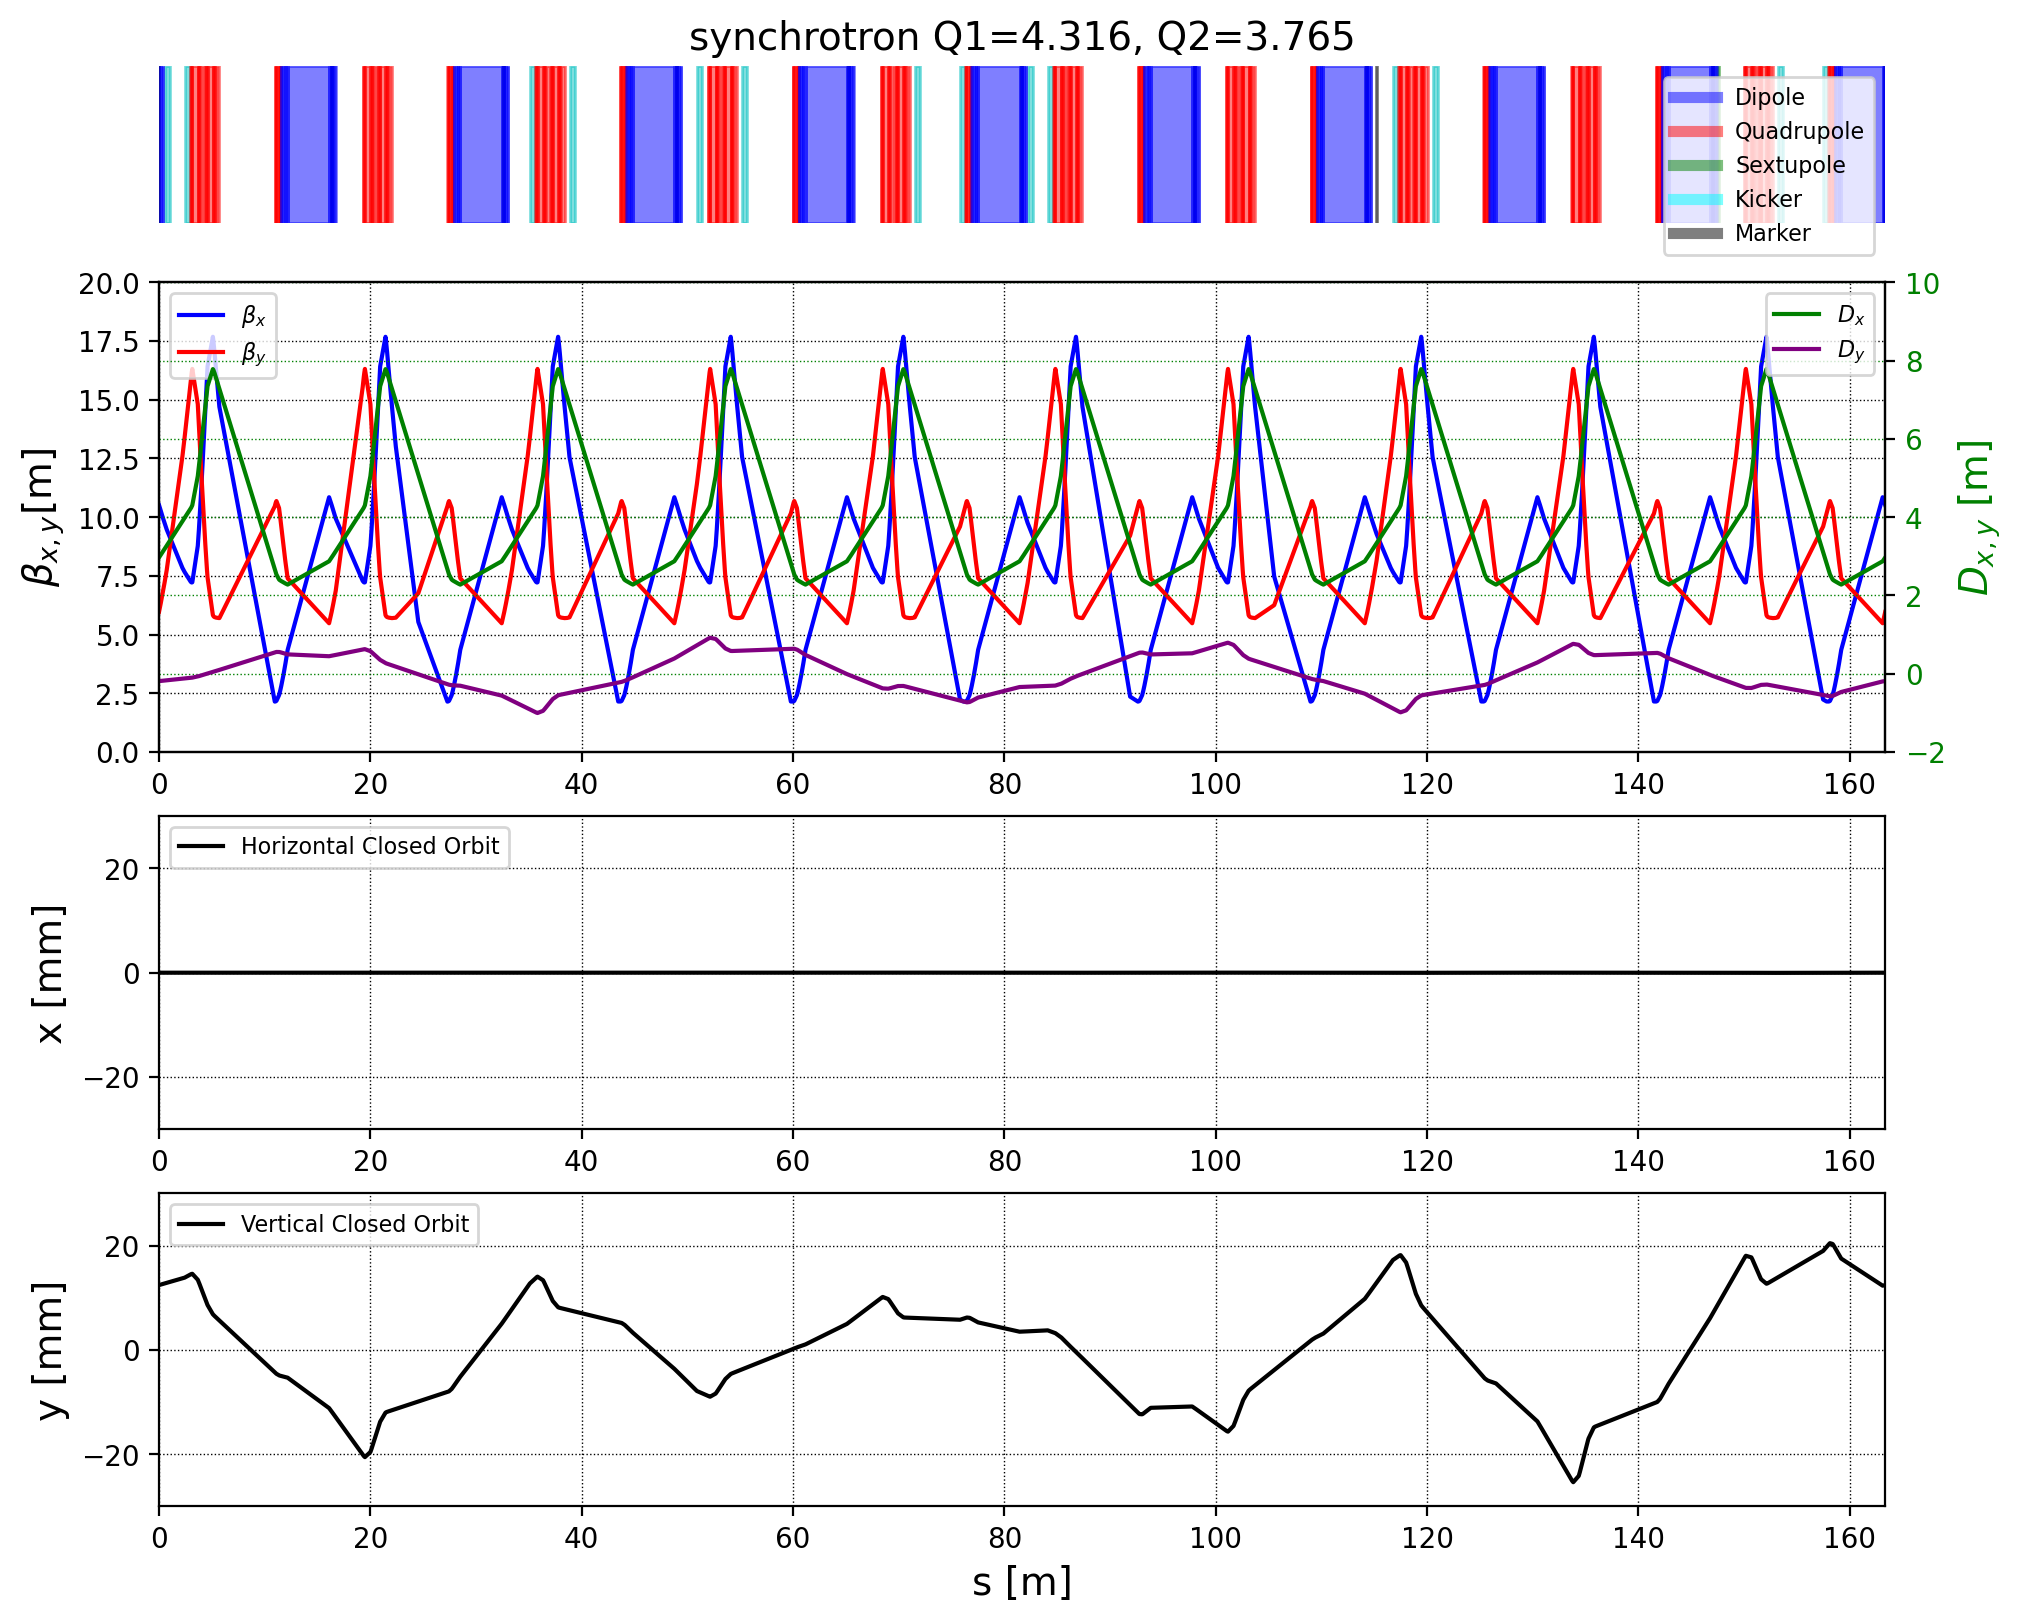

In [25]:
twiss_1 = cpymad_madx_twiss(madx, cpymad_logfile, sequence_name)
cpymad_plot_CO_plotly(madx, twiss_1, sequence_name, save_file=plot_folder+'/vertical_correctors_set_CO_plotly.png')
cpymad_plot_CO(madx, twiss_1, sequence_name, save_file=plot_folder+'/vertical_correctors_set_CO.png')  

In [26]:
h_corrector_currents_minus_0p4ms = {
 'r0hd1_kick': 5,
 'r2hd1_kick': -5,
 'r3hd1_kick': 10,
 'r4hd1_kick': 2,
 'r5hd1_kick': -2,
 'r7hd1_kick': -22,
 'r9hd1_kick': 15}

In [27]:
cpymad_set_correctors(madx, cpymad_logfile, h_corrector_currents_minus_0p4ms, max_E, cycle_time)

r0hd1_kick: 5.000000 A -> 0.291919 mrad
r2hd1_kick: -5.000000 A -> -0.318874 mrad
r3hd1_kick: 10.000000 A -> 0.559367 mrad
r4hd1_kick: 2.000000 A -> 0.092295 mrad
r5hd1_kick: -2.000000 A -> -0.108797 mrad
r7hd1_kick: -22.000000 A -> -1.166000 mrad
r9hd1_kick: 15.000000 A -> 0.803390 mrad


Sequence  synchrotron  is active.


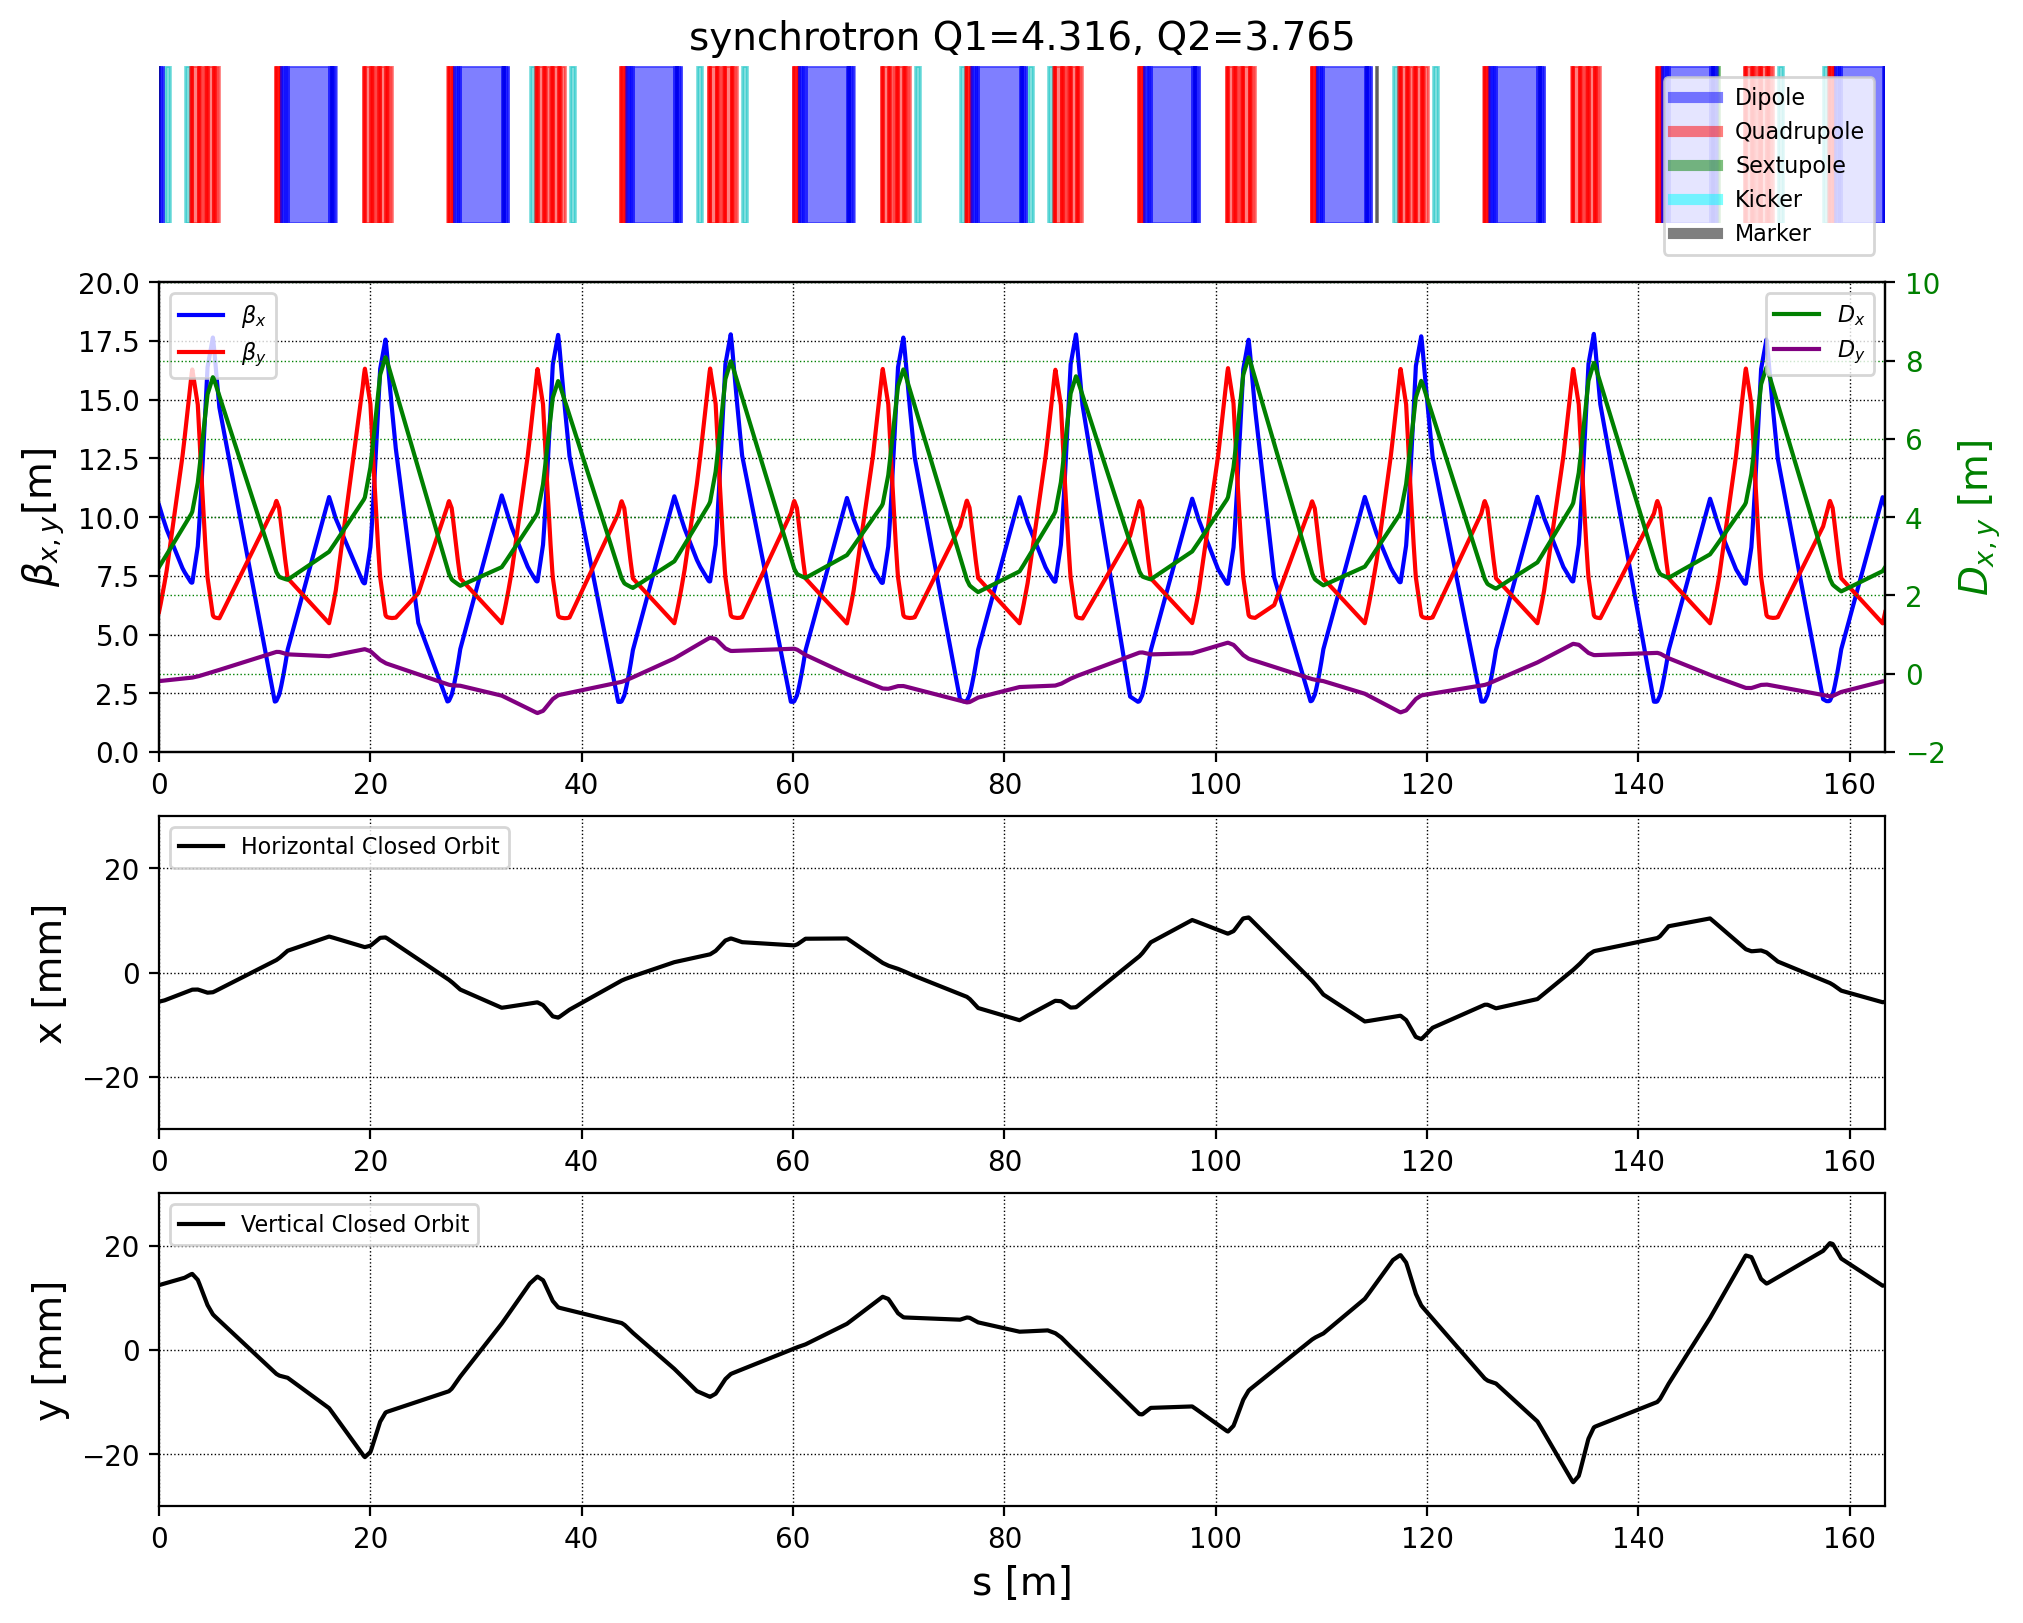

In [28]:
twiss_2 = cpymad_madx_twiss(madx, cpymad_logfile, sequence_name)
cpymad_plot_CO_plotly(madx, twiss_2, sequence_name, save_file=plot_folder+'/vertical_and_horizontal_correctors_set_CO_plotly.png')
cpymad_plot_CO(madx, twiss_2, sequence_name, save_file=plot_folder+'/vertical_and_horizontal_correctors_set_CO.png')  

Note that we can add limits for each superperiod like:

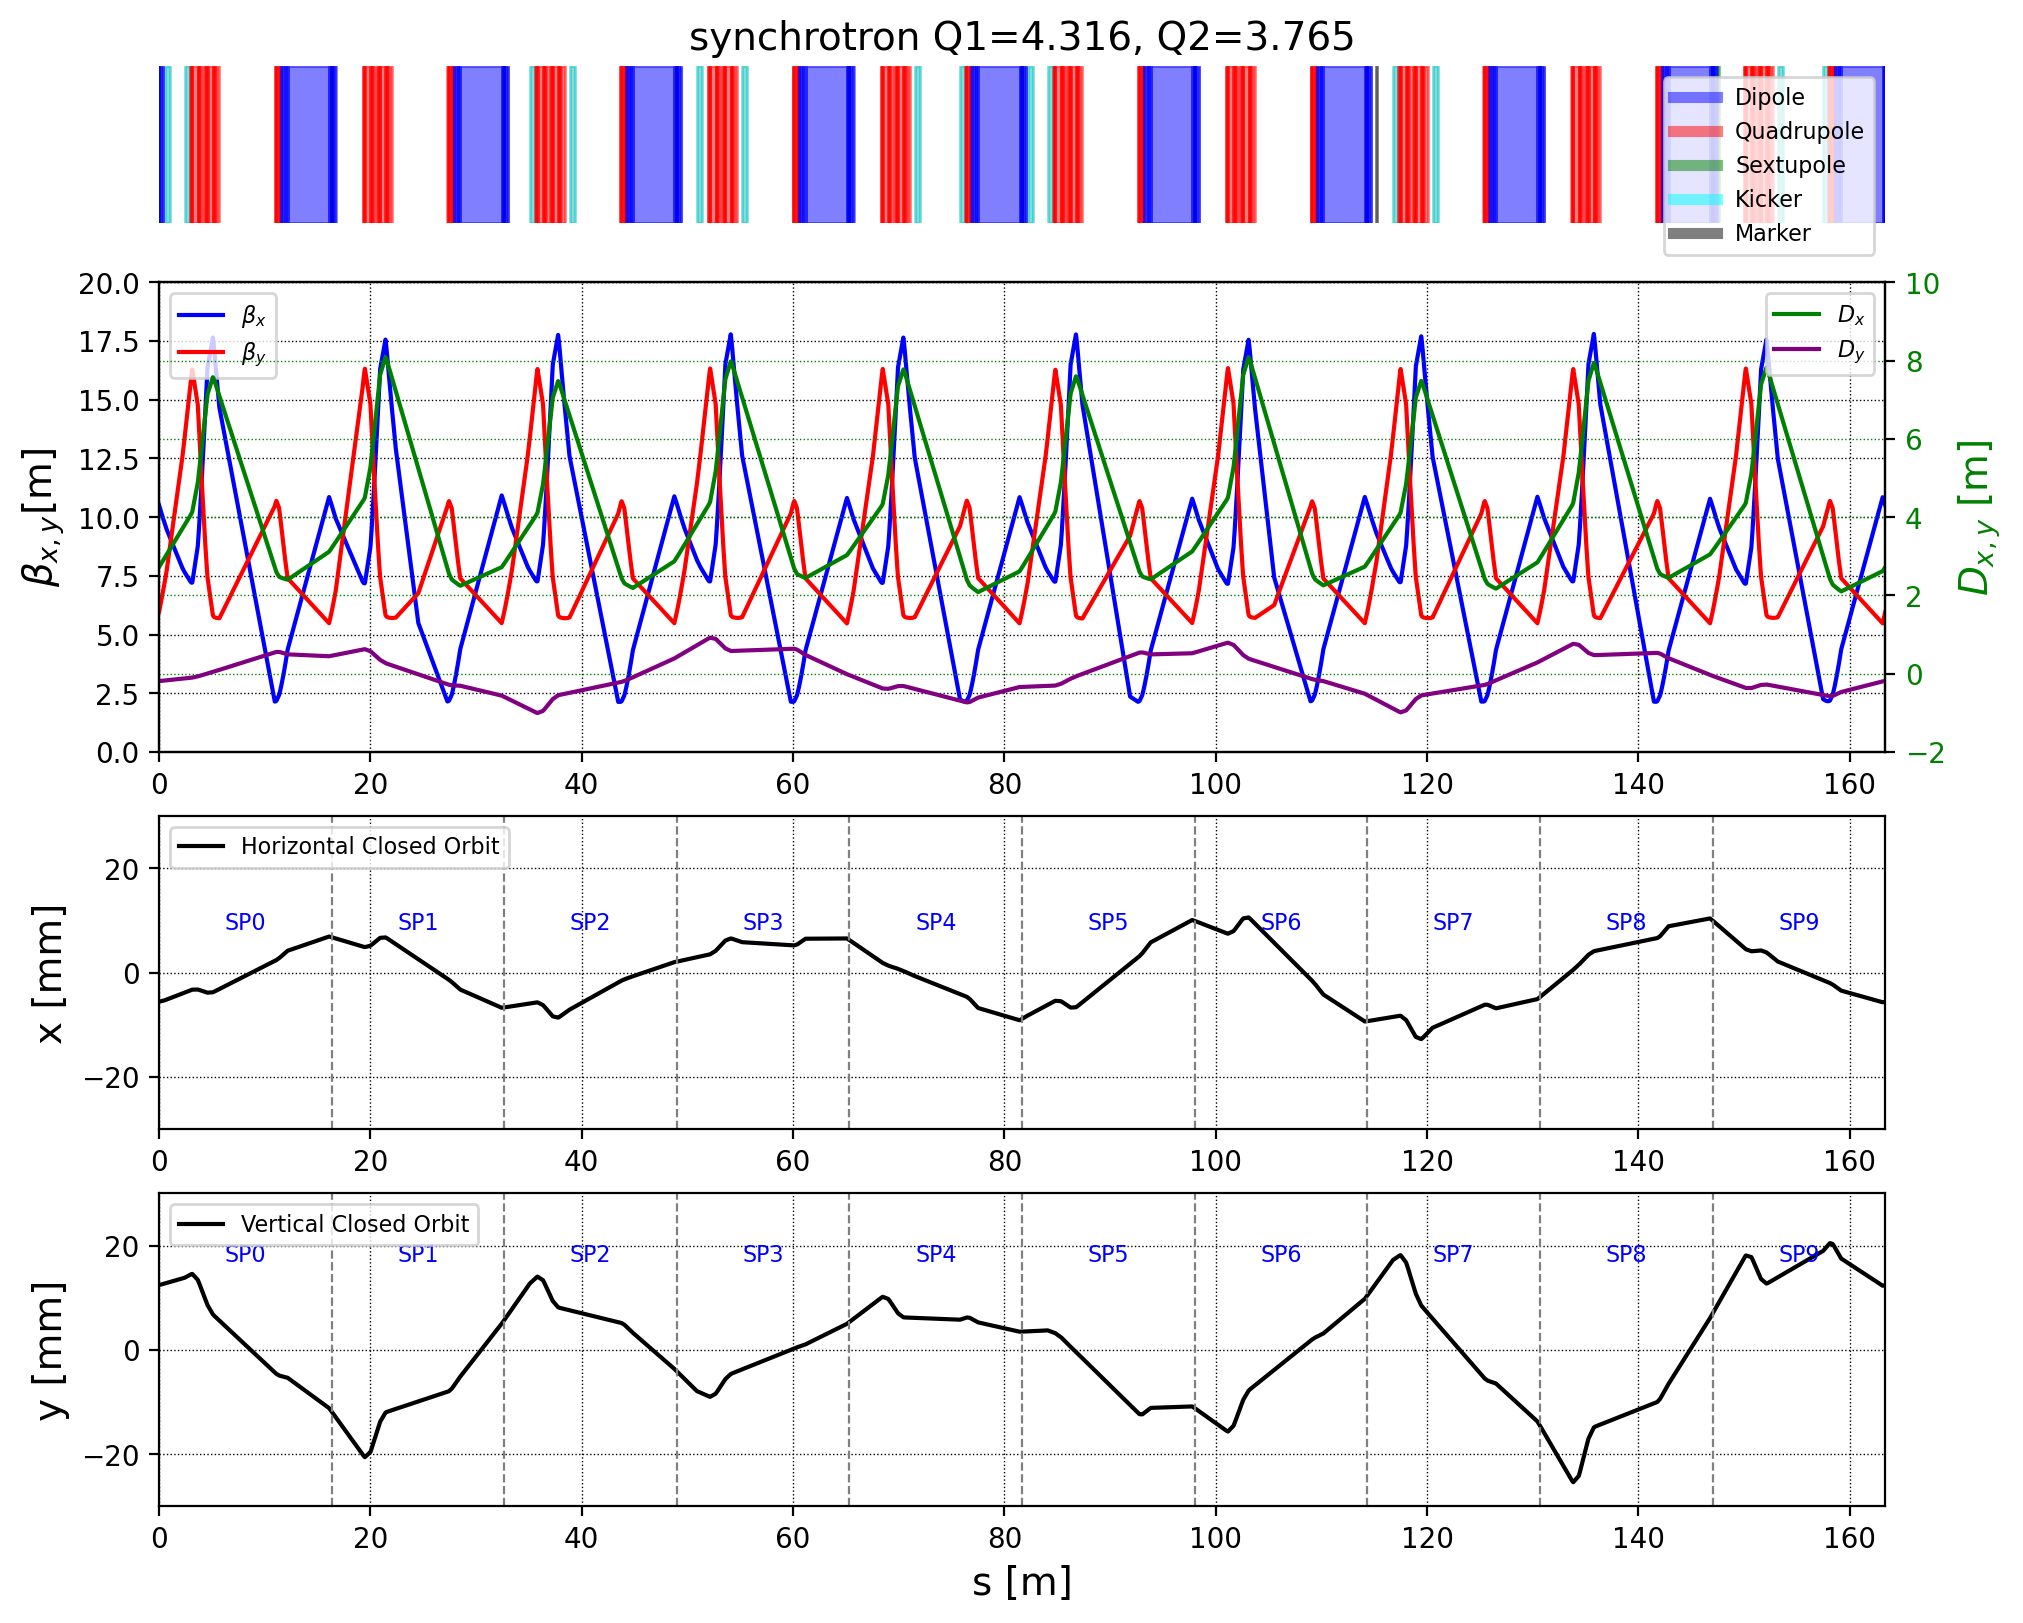

In [29]:
cpymad_plot_CO_sp(madx, twiss_2, sequence_name,  save_file=plot_folder+'/vertical_and_horizontal_correctors_set_CO_sp.png')  
cpymad_plot_CO_sp_plotly(madx, twiss_2, sequence_name, save_file=plot_folder+'/vertical_and_horizontal_correctors_set_CO_sp_plotly.png') 

Also the argument xlimits = [min, max] can be used to zoom in to a single superperiod:

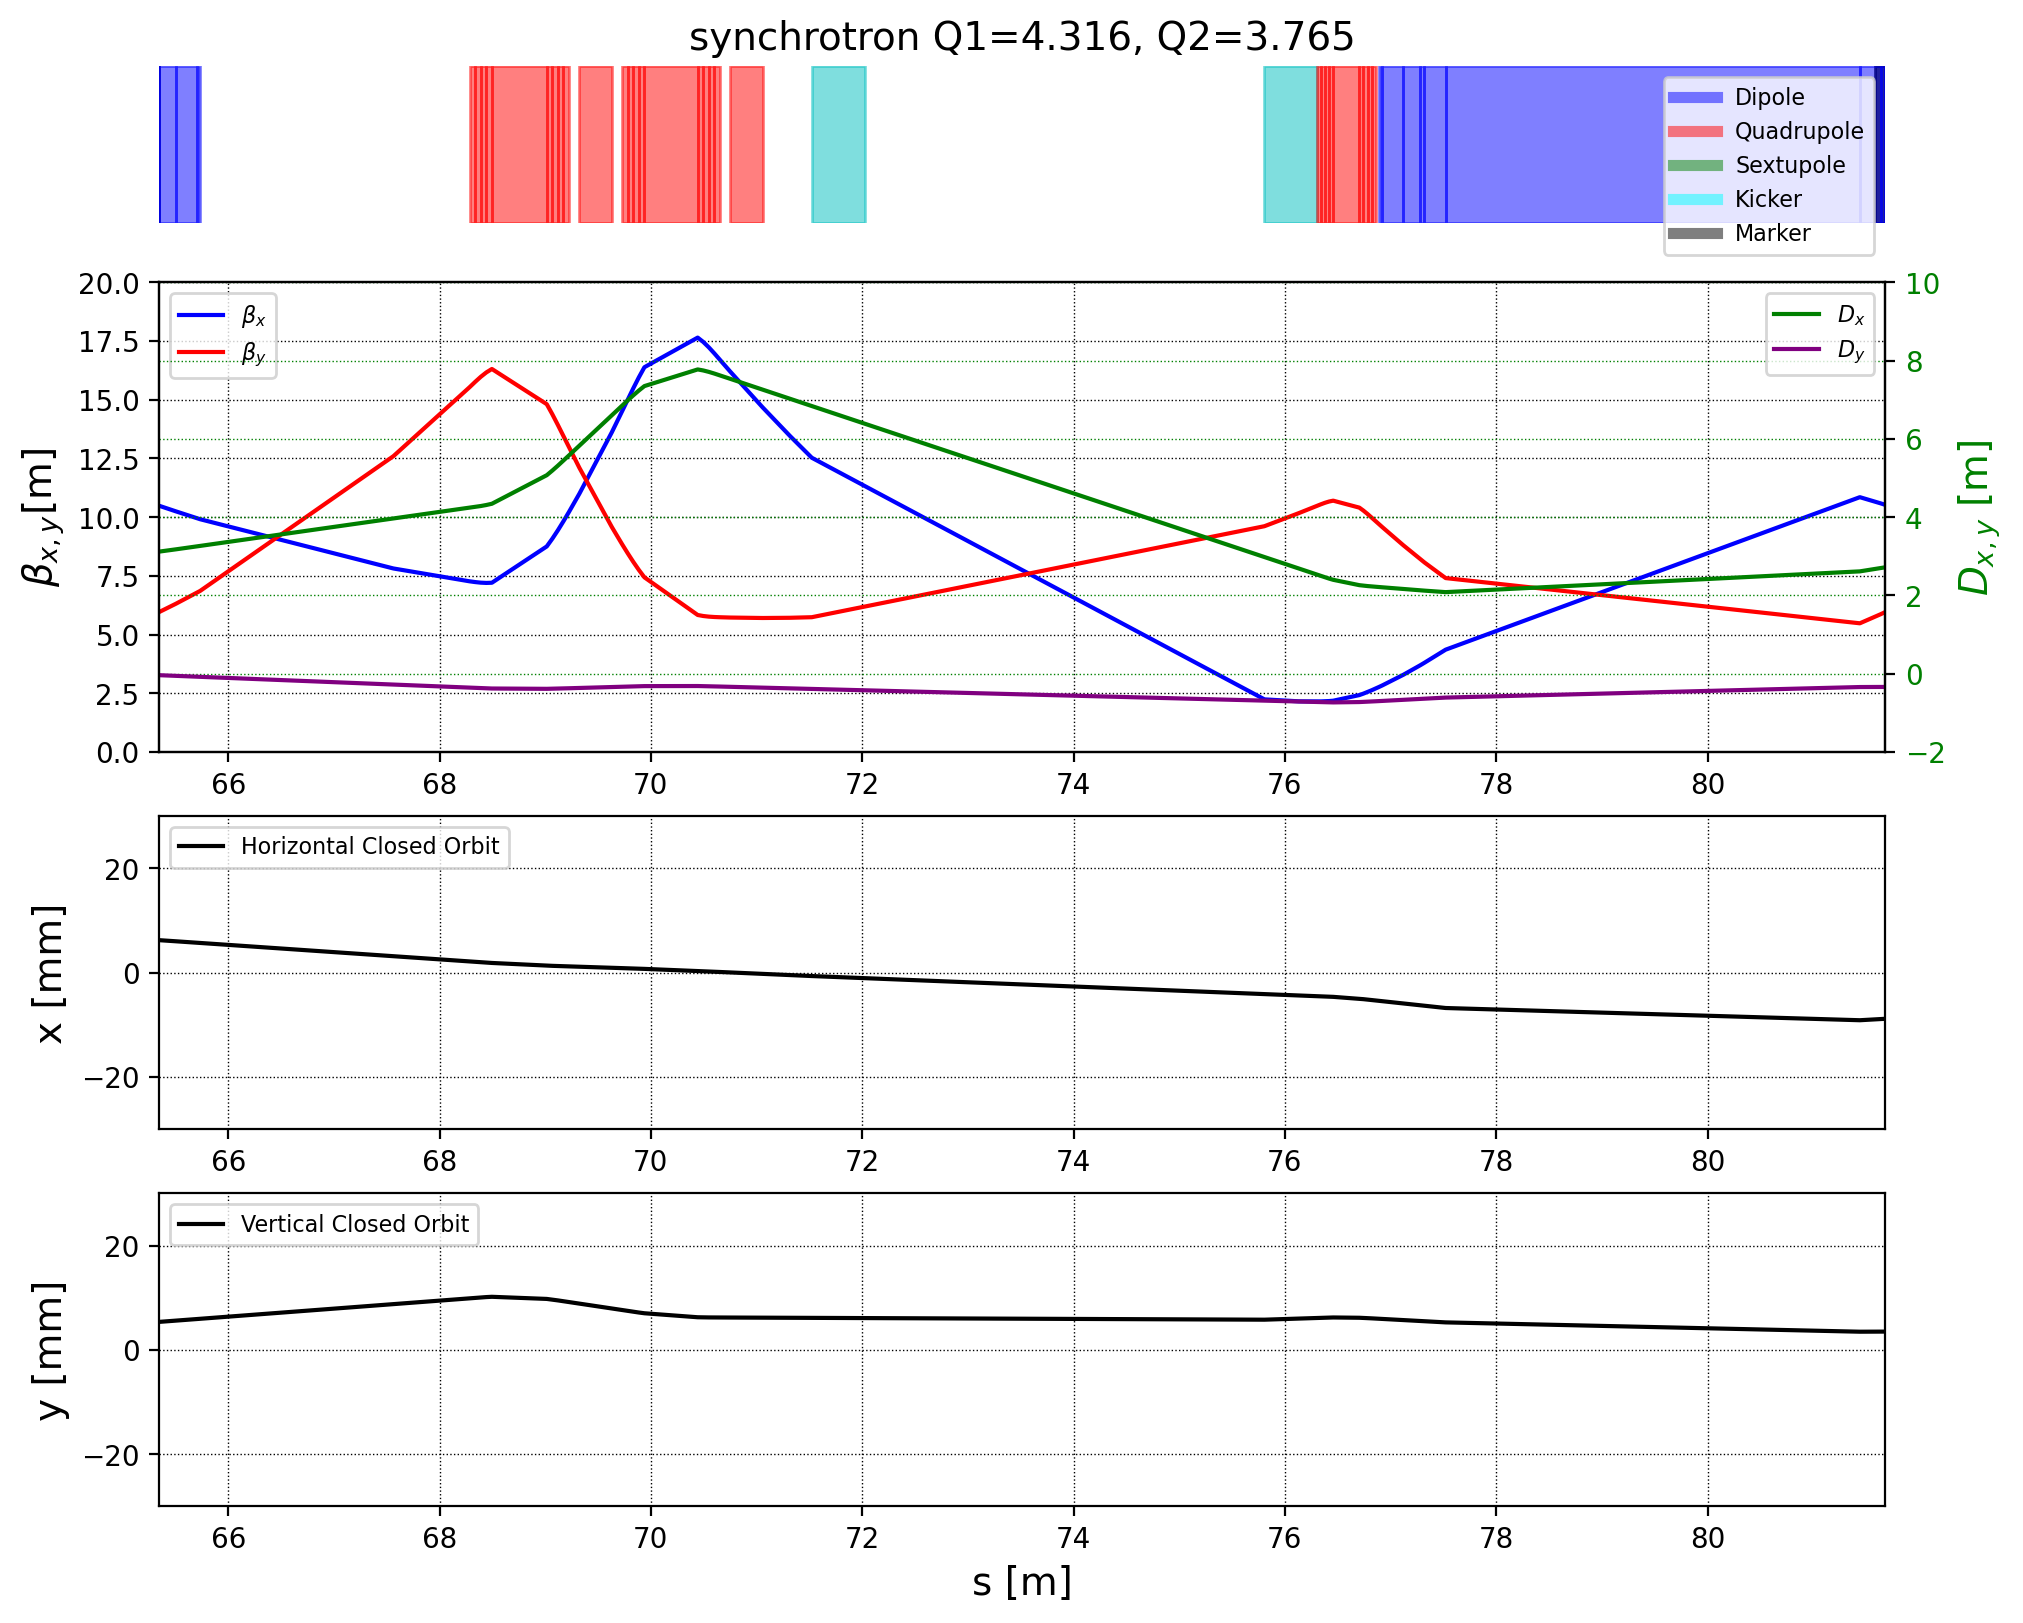

In [30]:
cpymad_plot_CO_plotly(madx, twiss_2, sequence_name, xlimits=[16.336282*4,16.336282*5], save_file=plot_folder+'/vertical_and_horizontal_correctors_set_CO_sp4_plotly.png')
cpymad_plot_CO(madx, twiss_2, sequence_name, xlimits=[16.336282*4,16.336282*5], save_file=plot_folder+'/vertical_and_horizontal_correctors_set_CO_sp4.png')  

# 6. Load measured data from **Beam Position Monitors (BPMs)**

Here we use the class defined at the top of the notebook `BPMFitResultsLoader` to load a file in the `Measurement_Data/` directory

In [31]:
loader_bare = BPMFitResultsLoader("Measurement_Data/bpm_fit_results_bare.txt", reverse_co=True)

We get the data in the format of a pandas dataframe like this:

In [32]:
df_bare = loader_bare.get_dataframe()
df_bare

,bpm,plane,beam_energy_mev,tune,tune_err,closed_orbit_mm,closed_orbit_mm_err,beta_h_mm,beta_v_mm,tune_spread,...,tune_shift_per_turn,tune_shift_per_turn_err,closed_orbit_shift_per_turn_mm,closed_orbit_shift_per_turn_mm_err,betatron_phase_rad,betatron_phase_rad_err,beta_h_mm_err,beta_v_mm_err,beta_err,revolution_frequency_hz
0,R0HM1,H,71.169700,0.349053,0.001151,8.680850,0.595611,-36.796347,NaN,0.052095,...,0.000043,0.000031,-0.100017,0.016043,-1.472247,0.045871,1.600348,NaN,1.600348,676818.371616
1,R1HM1,H,71.131093,0.353387,0.002119,19.231220,1.000791,-35.281484,NaN,0.052323,...,0.000020,0.000056,-0.101708,0.026544,-0.729431,0.085795,2.655363,NaN,2.655363,676723.251598
2,R3HM1,H,71.183747,0.349244,0.001316,15.960571,0.932198,-44.380802,NaN,0.045621,...,0.000045,0.000033,-0.078845,0.025116,-1.297203,0.057355,2.366905,NaN,2.366905,676849.639723
3,R4HM2,H,71.157002,0.348015,0.001384,25.623970,0.903232,45.153170,NaN,0.050404,...,0.000057,0.000036,-0.117610,0.024328,-1.603784,0.056933,2.374018,NaN,2.374018,676793.659356
4,R5HM1,H,71.186871,0.350013,0.001007,16.616077,0.668355,-44.680249,NaN,0.046150,...,0.000036,0.000024,-0.130620,0.017999,-2.169217,0.045844,1.599448,NaN,1.599448,676766.882002
5,R7HM1,H,71.176792,0.349969,0.001280,-3.289599,0.710255,36.572249,NaN,0.044113,...,0.000028,0.000030,-0.016088,0.019131,-0.399935,0.059255,1.676710,NaN,1.676710,676804.887135
6,R7HM2,H,71.194691,0.350586,0.001431,-0.850776,0.893168,46.465357,NaN,0.048031,...,0.000022,0.000035,-0.151526,0.024046,0.133000,0.064651,2.063864,NaN,2.063864,676634.732935
7,R8HM2,H,71.176921,0.350143,0.001145,36.094625,0.635676,-40.630221,NaN,0.048405,...,0.000022,0.000028,-0.109114,0.017119,-0.262548,0.050441,1.529911,NaN,1.529911,677033.373577
8,R9HM1,H,71.190684,0.350405,0.001079,9.724558,0.750310,45.994944,NaN,0.045579,...,0.000015,0.000026,-0.138057,0.020214,-0.608054,0.048278,1.836845,NaN,1.836845,676751.125131
9,R0VM1,V,70.276242,0.810321,0.003657,16.802323,2.315782,NaN,-41.242191,0.042267,...,0.000042,0.000084,-0.825672,0.064360,-0.207445,0.176066,NaN,5.043795,5.043795,669253.469092


For a single plane the parameters are extracted for plotting like:

In [33]:
loader_bare.get_plane_parameters('V', ['closed_orbit_mm'])

,bpm,closed_orbit_mm
9,R0VM1,16.802323
10,R3VM1,0.705453
11,R3VM2,-5.478769
12,R4VM1,4.840785
13,R4VM2,9.982298
14,R6VM1,-5.152559
15,R7VM2,12.120444
16,R8VM1,-9.795404
17,R9VM2,5.144455


We can use an existing **twiss** table to add locate the monitors in the lattice and find their comoving co-ordinate **s**

In [34]:
loader_bare.get_co_data('V', twiss_0)

,bpm,closed_orbit_mm,closed_orbit_mm_err,s
9,R0VM1,-16.802323,2.315782,2.218000
10,R3VM1,-0.705453,0.638552,49.739346
11,R3VM2,5.478769,0.619571,51.226846
12,R4VM1,-4.840785,0.680134,67.563128
13,R4VM2,-9.982298,0.930289,76.131928
14,R6VM1,5.152559,0.602650,100.235692
15,R7VM2,-12.120444,0.620293,116.571974
16,R8VM1,9.795404,1.115659,132.908256
17,R9VM2,-5.144455,0.671270,149.244538


Let's combine the above functions to have a complete set of code to load the measurement data

In [35]:
bpm_bare = BPMFitResultsLoader("Measurement_Data/bpm_fit_results_bare.txt", reverse_co=False)
bare_h = bpm_bare.get_co_data('H', twiss_0)
bare_v = bpm_bare.get_co_data('V', twiss_0)

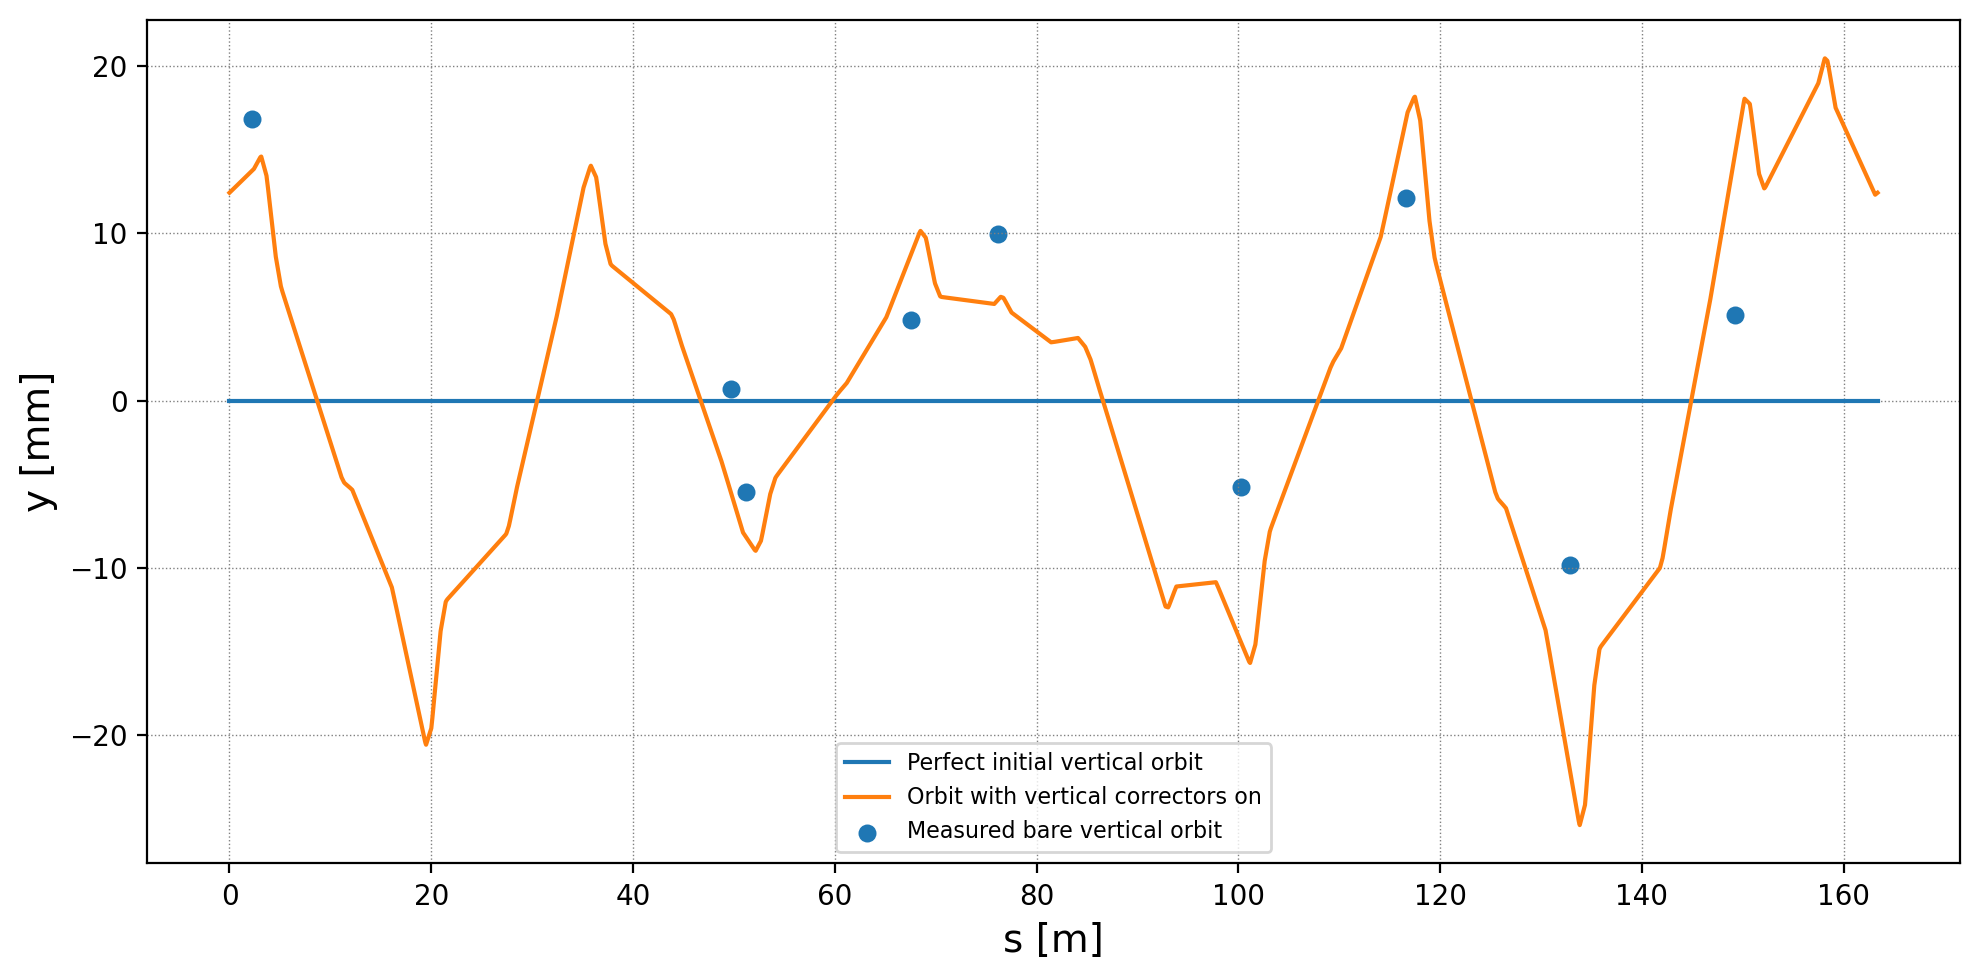

In [36]:
plt.figure(figsize=(10, 5))

# Plot model orbits
plt.plot(twiss_0.s, twiss_0.y * 1e3, label='Perfect initial vertical orbit')
plt.plot(twiss_1.s, twiss_1.y * 1e3, label='Orbit with vertical correctors on')

# Plot measured orbit
plt.scatter(bare_v['s'], bare_v['closed_orbit_mm'], label='Measured bare vertical orbit', s=30, marker='o')

# Formatting
plt.grid(which='both', linestyle=':', linewidth=0.5, color='grey')
plt.xlabel('s [m]')
plt.ylabel('y [mm]')
plt.legend()
# plt.title('Comparison of bare orbit inferred from survey misalignments and measured bare orbit (chopped)')
plt.tight_layout()

# Save the figure
plt.savefig(plot_folder + '/Orbit_vs_measurement.png', bbox_inches='tight', dpi=300)

import plotly.graph_objects as go

# Create a figure
fig = go.Figure()

# Plot model orbits
fig.add_trace(go.Scatter(x=twiss_0.s, y=twiss_0.y * 1e3, mode='lines', name='Perfect initial vertical orbit'))
fig.add_trace(go.Scatter(x=twiss_1.s, y=twiss_1.y * 1e3, mode='lines', name='Orbit with vertical correctors on'))

# Plot measured orbit
fig.add_trace(go.Scatter(x=bare_v['s'], y=bare_v['closed_orbit_mm'], mode='markers', name='Measured bare vertical orbit', marker=dict(size=8)))

# Update layout for grid, labels, and other aesthetics
fig.update_layout(
    title='Comparison of bare orbit inferred from survey misalignments and measured bare orbit (chopped)',  # Optional title
    xaxis=dict(title='s [m]'),
    yaxis=dict(title='y [mm]'),
    template="plotly_white",  # Use a clean white background
    showlegend=True,
    xaxis_showgrid=True,
    yaxis_showgrid=True,
    xaxis_gridwidth=0.5,
    yaxis_gridwidth=0.5,
    xaxis_gridcolor='lightgrey',
    yaxis_gridcolor='lightgrey'
)

# Save the figure to a file
fig.show()


#### Close the `MAD-X` object to free up memory

In [37]:
madx.quit()